In [191]:
%pylab inline
import astropy.units as u
from numba import jit
import numpy as np
import matplotlib.pyplot as plt
import batoid
from LSSTFringe import utils,plot_utils,TMMSIM
index_of_refraction = utils.load_refraction_data(Epoxy_ind=1.6,Temp = 173.)
from astropy.io import fits
import os
from tqdm import tqdm


Populating the interactive namespace from numpy and matplotlib


In [4]:
@jit(nopython = True,nogil=True)
def E2V_model(n_list,epoxy_um, wlen):
    
    thickness_um = np.array([np.inf, 0.1221,0.0441,100, 0.1, 0.3,1.,epoxy_um,165, np.inf])

    # Assume normal incidence.
    theta = 0.
    R = T = 0
    for pol in 's':

        # Using tmm package to do multilayer thin-film simulation
        Res = TMMSIM.coh_tmm(pol, n_list, thickness_um, theta, 1e-3 * wlen)
        # Store R and T results
        rr,tt = Res[2],Res[3]
        R += rr
        T += tt

    A = 1 - R - T

    return(A)

# Define the gaussian function
@jit(nopython = True,nogil=True)
def gaussian(x, mu, FWHM):

    # Calculate sigma based on FWHM value 2nm
    # FWHM = 2*sqrt(2*ln2)*sigma
    sig = FWHM/(2*np.sqrt(2*np.log(2)))

    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-((x - mu)/sig)**2/2)


@jit(nopython = True,nogil=True)
def map_sim(n_list,thickmap,wlen):
    Fringe_map = np.zeros_like(thickmap)
    for i in range(len(thickmap)):
        Fringe_map[i] = E2V_model(n_list = n_list,epoxy_um = thickmap[i],wlen=wlen)
    return(Fringe_map)

In [200]:
wlen = 909.4894
pol = 's'
material = ('Vacuum', 'MgF2','Ta2O5', 'Si_Temp', 'SiO2', 'Si_Temp', 'SiO2','Epoxy','Si_Temp','Si3N4')
n_list = np.array([index_of_refraction[m](wlen) for m in material])
thickness_um = np.array([np.inf, 0.1221,0.0441,202.4, 0.1, 0.3,1.,14,165, np.inf])
Res = TMMSIM.coh_tmm(pol, n_list, thickness_um, 8*pi/180, 1e-3 * wlen)
Abor_prob = TMMSIM.absorp_in_each_layer(Res)[3]
print(Abor_prob)

0.8734480571903157


In [6]:
wavelength = np.arange(650., 1050., 1)
MAP = np.arange(15,15.5,0.01)
Fringe_amp2 = []
for m in tqdm(range(len(wavelength))):
    avg_wlen_width = 2
    window =80
    cen_wav = wavelength[m]
    x = np.linspace(cen_wav-2*avg_wlen_width,cen_wav+2*avg_wlen_width,window+1)
    # Assign weight to each point based on the gaussian
    weight = gaussian(x,cen_wav,avg_wlen_width)
    Fringe_map = np.zeros_like(MAP)

    for k in (range(len(x))):
        wlen = x[k]
        material = ('Vacuum', 'MgF2','Ta2O5', 'Si_Temp', 'SiO2', 'Si_Temp', 'SiO2','Epoxy','Si_Temp','Si3N4')
        n_list = np.array([index_of_refraction[m](wlen) for m in material])
        Fringe_map += weight[k]*map_sim(n_list,MAP,wlen = x[k])
    Fringe_map = Fringe_map/np.sum(weight)       
    a = (np.max(Fringe_map)+np.min(Fringe_map))/2
    A = (Fringe_map)-a
    Fringe_amp2.append(A[0])

100%|█████████████████████████████████████████| 400/400 [00:32<00:00, 12.31it/s]


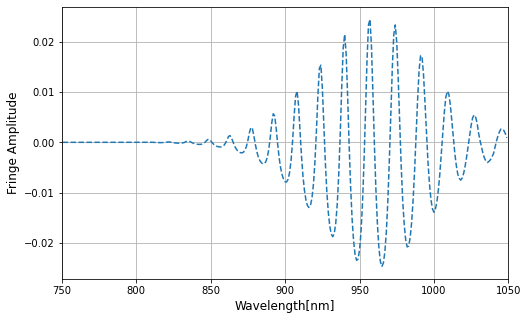

In [7]:
plt.figure(figsize = (8,5))
#plt.plot(wavelength[50:400],Fringe_amp[50:400])
plt.plot(wavelength[50:400],Fringe_amp2[50:400],'--')
plt.grid()
plt.xlim(750,1050)
plt.xlabel('Wavelength[nm]',fontsize = 12)
plt.ylabel('Fringe Amplitude',fontsize = 12);

In [43]:
# Generate Simulation data for fitting
wavelength = np.arange(880., 1000., 10)
for i in tqdm(range(60)):
    MAP = np.arange(1+i*0.5,1+(i+1)*0.5,0.001)
    Fringe_amp = []
    for m in(range(len(wavelength))):

        avg_wlen_width = 2
        window =40

        cen_wav = wavelength[m]
        x = np.linspace(cen_wav-2*avg_wlen_width,cen_wav+2*avg_wlen_width,window+1)

        # Assign weight to each point based on the gaussian
        weight = gaussian(x,cen_wav,avg_wlen_width)

        Fringe_map = np.zeros_like(MAP)
        
        for k in (range(len(x))):
            wlen = x[k]
            material = ('Vacuum', 'MgF2','Ta2O5', 'Si_Temp', 'SiO2', 'Si_Temp', 'SiO2','Epoxy','Si_Temp','Si3N4')
            n_list = np.array([index_of_refraction[m](wlen) for m in material])
            Fringe_map += weight[k]*map_sim(n_list,MAP,wlen = x[k])
        Fringe_map = Fringe_map/np.sum(weight)       
        a = (np.max(Fringe_map)+np.min(Fringe_map))/2
        A = (Fringe_map)-a
        Fringe_amp.append(A)
    Fringe_amp = np.array(Fringe_amp)
    if i == 0 :
        Result = numpy.transpose(Fringe_amp)
        Epoxythickness = MAP
    else:
        Result = np.vstack((Result,numpy.transpose(Fringe_amp)))
        Epoxythickness = np.hstack((Epoxythickness,MAP))

100%|███████████████████████████████████████████| 60/60 [03:01<00:00,  3.03s/it]


In [15]:
Result.shape,Epoxythickness.shape

((30000, 16), (30000,))

In [ ]:
os.chdir('../AstroCCD-master/data/Nice-Sample/E2V-321/')

In [49]:
wlen_data = np.arange(880,1000,10)

In [44]:

flat_files = ['E2V-321-870.fits',     'E2V-321-880.fits',      'E2V-321-890.fits',
'E2V-321-900.fits'    , 'E2V-321-910.fits' ,'E2V-321-920.fits',
'E2V-321-930.fits'    , 'E2V-321-940.fits'  ,    'E2V-321-950.fits',
'E2V-321-960.fits'    , 'E2V-321-970.fits'   ,   'E2V-321-980.fits',
'E2V-321-990.fits'     , 'E2V-321-1000.fits'    ]#,  'E2V-321-1010.fits',
#'E2V-321-1020.fits'     , 'E2V-321-1030.fits']

from scipy.ndimage import gaussian_filter
# Chop image, discarding bad quality pixels on the edge
# And gaussian smoothing the image per wavelength
good_wlen = [880,890,900,910,920,930,940,950,960,970,980,990]
Fringe_amps_data = []
error_data = []
#for i,Range in enumerate(index_min) :

TS_amp = []
Fringe_amps = []
TS_amp_err = []
error = []
for file in flat_files[1:-1]:
        
    assem = fits.open(file)
    assembled = assem[0].data
    big = assembled[15:-15,48:-48]
    
    smoothed = gaussian_filter(big, sigma=3)
    smoothed = smoothed/np.mean(smoothed)-1
    TS_amp.append(smoothed)

In [48]:
TS_amp.shape

(12, 3974, 4000)

In [47]:
# Construct the Fringe Amp. Cube array 'B' from Flat cube
TS_amp = np.array(TS_amp)
print(TS_amp.shape)
A = np.transpose(TS_amp.reshape(12,3974*4000))
B = A.reshape(3974,4000,12)

(12, 3974, 4000)


Paper Figure 4

18566


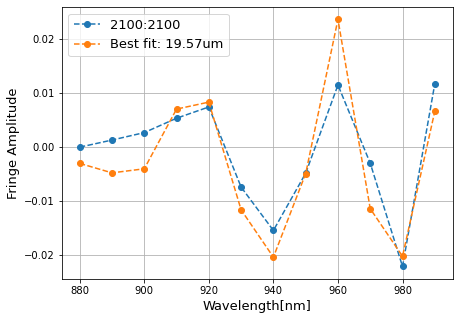

In [57]:
# Compare data and theory for an arbitary pixel
# Starting pixel for fitting
plt.figure(figsize = (7,5))
point = B[0,0]
#plt.errorbar(good_wlen,A[ii],yerr = 0.007,fmt = '--o',capsize = 3,label = 'SLAC-TS8')
plt.plot(wlen_data,point,'o--',label = '2100:2100')
chi2 = np.sum((np.square((Result-point)))/11, axis=1)
index = np.argmin(chi2)
#begin_index = index
plt.plot(wlen_data,Result[index],'o--',label = 'Best fit: %.2fum'%Epoxythickness[index])
plt.xlabel('Wavelength[nm]',fontsize = 13)
plt.ylabel('Fringe Amplitude',fontsize = 13)
plt.legend(loc = 'best',fontsize = 13,frameon = True)
plt.grid()
print(index)
#plt.savefig('../../Paper_plots/fit_example.eps')

In [58]:
thickness_map = np.ones((3974,4000))
R = 100
index = 18566

In [59]:
# Descending scheme
starting_row = 0
starting_column = 0

point = B[starting_row,starting_column]
thickness_map[starting_row,starting_column] = Epoxythickness[index]

R = 100
    
# descending
index = 18565
for j in range(len(thickness_map[-1,starting_column+1:])):
    row = starting_row 
    column = j + starting_column+1
    #print(column)
    ###################
    chi2 = np.sum((np.square((Result[index-R:index+R]-B[row,column])))/11, axis=1)
    sub_index = np.argmin(chi2)
    index = index + sub_index - R
    thickness_map[row,column] = Epoxythickness[index]
    ###################
    
reverse = True
for i in tqdm(range(len(thickness_map[:,-1])-starting_row-1)):
    row = starting_row + 1 + i
    if reverse == False:
        for j in range(len(thickness_map[-1,:])):
            column = j
            ###################
            chi2 = np.sum((np.square((Result[index-R:index+R]-B[row,column])))/11, axis=1)
            sub_index = np.argmin(chi2)
            index = index + sub_index - R
            thickness_map[row,column] = Epoxythickness[index]
            ###################
        reverse = True
    else:
        for j in range(len(thickness_map[-1,:])):
            column = len(thickness_map[-1,:]) - j - 1
            ###################
            chi2 = np.sum((np.square((Result[index-R:index+R]-B[row,column])))/11, axis=1)
            sub_index = np.argmin(chi2)
            index = index + sub_index - R
            thickness_map[row,column] = Epoxythickness[index]
            ###################
        reverse = False    

100%|███████████████████████████████████████| 3973/3973 [05:09<00:00, 12.85it/s]


In [55]:
# Ascending scheme
for j in range(starting_column):
    row = starting_row
    column = starting_column-(j+1)
    ###################
    chi2 = np.sum((np.square((Result[index-R:index+R]-B[row,column])))/11, axis=1)
    sub_index = np.argmin(chi2)
    index = index + sub_index - R
    thickness_map[row,column] = Epoxythickness[index]
    ###################
    #print('')

reverse = False
for i in tqdm(range(starting_row)):
    row = starting_row -(1 + i)
    if reverse == False:
        for j in range(len(thickness_map[-1,:])):
            column = j
            ###################
            chi2 = np.sum((np.square((Result[index-R:index+R]-B[row,column])))/11, axis=1)
            sub_index = np.argmin(chi2)
            index = index + sub_index - R
            thickness_map[row,column] = Epoxythickness[index]
            ###################
        reverse = True
    else:
        for j in range(len(thickness_map[-1,:])):
            column = len(thickness_map[-1,:]) - j - 1
            ###################
            chi2 = np.sum((np.square((Result[index-R:index+R]-B[row,column])))/11, axis=1)
            sub_index = np.argmin(chi2)
            index = index + sub_index - R
            thickness_map[row,column] = Epoxythickness[index]
            ###################
        reverse = False

100%|███████████████████████████████████████| 2100/2100 [02:51<00:00, 12.21it/s]


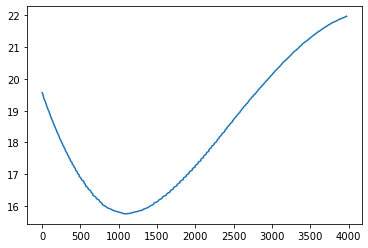

In [60]:
# Plot the diagnal componet of the derived thickness map
plt.plot(np.diag(thickness_map))

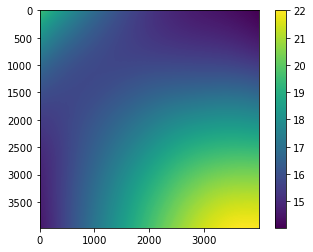

In [61]:
plt.imshow(thickness_map)
plt.colorbar();